In [ ]:
!pip install opencv-python

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import keras
from sklearn.metrics import f1_score
import cv2
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D, Input
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from sklearn.utils import shuffle

In [49]:
datapath = "dataset/"
img_width, img_height = 224,224
classes = ["manipuri", "bharatanatyam", "odissi", "kathakali", "kathak", "sattriya", "kuchipudi", "mohiniyattam"]
class_names_label = {classes:i for i, classes in enumerate(set(classes))}
num_classes = len(classes)
# resnet_weights_path = 'resnet_weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
# resnet_weights_path = ('https://github.com/fchollet/deep-learning-models/'
#                        'releases/download/v0.2/'
#                        'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [50]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [51]:
def load_images(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height),interpolation=cv2.INTER_CUBIC)
    return resized

def norm_images(images):
    images = np.array(images,dtype = 'float32') / 255.  
    mean_img = np.mean(images,axis = 0)
    std_img = np.std(images,axis = 0)
    norm_img = (images - mean_img)/std_img
    return norm_img

def load_dataset(folder_name):
    images = []
    labels = []
    label_file = pd.read_csv(os.path.join(datapath,folder_name+".csv"))
    for file in tqdm(os.listdir(os.path.join(datapath,folder_name))):
        if(folder_name == "train"):
            label = class_names_label[label_file[label_file["Image"] == file]["target"].values[0]]
            labels.append(label)
        else:
            labels.append(file)
        image = load_images(os.path.join(datapath,folder_name,file))
#         image = norm_images(image)
        images.append(image)
    images = norm_images(images)
    return (images,labels)

In [52]:
(x_train, y_train)=load_dataset("train")
x_train,y_train = shuffle(x_train,y_train,random_state = 42)
(x_test, img_name) = load_dataset("test")
y_train = np.array(y_train, dtype = 'int16')
y_train = to_categorical(y_train)

print(y_train.shape)

100%|██████████| 156/156 [00:00<00:00, 200.05it/s]


(364, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

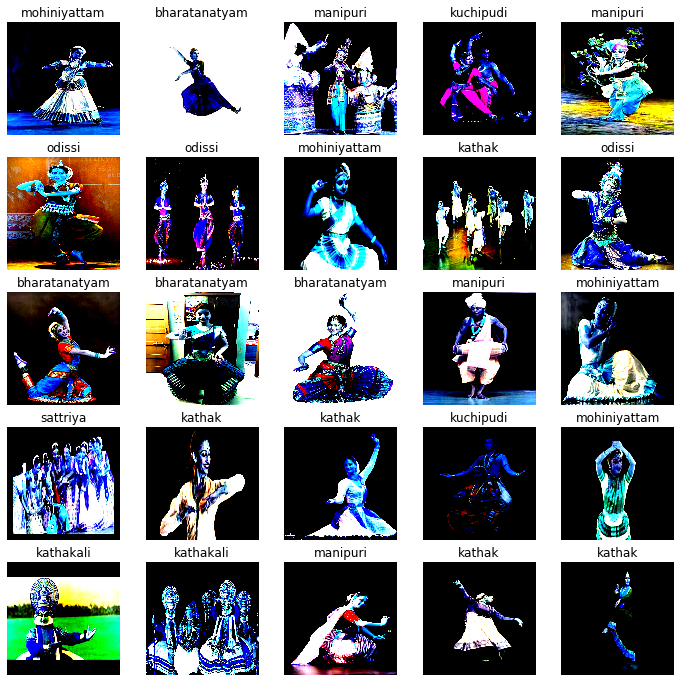

In [53]:
def show_batch(image_batch, label_batch):
    y_maps = dict()
    y_maps = {v:k for k,v in class_names_label.items()}
#     print(y_maps)
    plt.figure(figsize=(12,12))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        pred = np.argmax(label_batch[n])
#         print(pred)
        plt.title(y_maps[pred])
        plt.axis('off')
show_batch(x_train,y_train)

In [63]:
def generate_sol(name, model):
    predictions = model.predict(x_test)
    predictions = np.argmax(predictions,axis = 1)
    y_maps = dict()
    y_maps = {v:k for k,v in class_names_label.items()}
    print(y_maps)
    print(predictions)
    pred_labels = [y_maps[k] for k in predictions]
    print(pred_labels)
    sub = pd.DataFrame({'Image':img_name,'target':pred_labels})
    model.save('resnet_weights/'+name+'weights.h5')
    sub.to_csv(name+'sol.csv', index = False)

In [56]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 40, width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.3)
#val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(x_train, y_train,shuffle = True,subset="training",batch_size=32)
val_generator = datagen.flow(x_train, y_train,shuffle = True,subset = "validation", batch_size=32)
#val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=30)

# Experiment 1

In [64]:
cnnmodel = Sequential()
cnnmodel.add(Convolution2D(32, (3,3), activation='relu', padding='same',input_shape = (img_width, img_height,3)))
cnnmodel.add(Convolution2D(32, (3,3), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2,2)))

cnnmodel.add(Convolution2D(64, (3,3), activation='relu', padding='same'))
cnnmodel.add(Convolution2D(64, (3,3), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2,2)))
cnnmodel.add(Dropout(0.25))

cnnmodel.add(Convolution2D(128, (3,3), activation='relu', padding='same'))
cnnmodel.add(Convolution2D(128, (3,3), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2,2)))
cnnmodel.add(Dropout(0.25))

cnnmodel.add(Flatten())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(256, activation='relu'))
cnnmodel.add(Dropout(0.25))
cnnmodel.add(Dense(y_train.shape[1], activation='softmax'))
cnnmodel.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
cnnmodel.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 54, 54, 64)       

In [65]:
early_stops = EarlyStopping(patience=3, monitor='val_accuracy')

cnnmodel.fit(x_train, y_train, batch_size=100, epochs=20, validation_split=0.3, callbacks=[early_stops])
generate_sol("cnn", cnnmodel)

Train on 254 samples, validate on 110 samples
Epoch 1/20
254/254 [==============================] - 19s 73ms/step - loss: 2.7097 - accuracy: 0.1220 - val_loss: 2.0737 - val_accuracy: 0.1364
Epoch 2/20
254/254 [==============================] - 18s 72ms/step - loss: 2.0893 - accuracy: 0.1260 - val_loss: 2.0764 - val_accuracy: 0.1364
Epoch 3/20
254/254 [==============================] - 18s 72ms/step - loss: 2.0763 - accuracy: 0.1299 - val_loss: 2.0704 - val_accuracy: 0.1364
Epoch 4/20
254/254 [==============================] - 19s 73ms/step - loss: 2.0683 - accuracy: 0.1457 - val_loss: 2.0678 - val_accuracy: 0.2091
Epoch 5/20
254/254 [==============================] - 18s 72ms/step - loss: 2.0541 - accuracy: 0.1890 - val_loss: 2.0409 - val_accuracy: 0.2091
Epoch 6/20
254/254 [==============================] - 23s 92ms/step - loss: 2.0155 - accuracy: 0.2165 - val_loss: 1.9832 - val_accuracy: 0.1636
Epoch 7/20
254/254 [==============================] - 25s 99ms/step - loss: 1.9644 - accur

# Experiment 1 with data augumentation

In [ ]:
history = cnnmodel.fit_generator(train_generator, steps_per_epoch=100, epochs=10,
                          validation_data=val_generator, validation_steps=50, verbose=1)
generate_sol("cnndataaug",cnnmodel)

Epoch 1/10
100/100 [==============================] - 379s 4s/step - loss: 2.0777 - accuracy: 0.1399 - val_loss: 2.0740 - val_accuracy: 0.1203
Epoch 2/10
 31/100 [========>.....................] - ETA: 3:49 - loss: 2.0748 - accuracy: 0.1377

# Transfer Learning With ResNet50 

In [44]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet',input_tensor=Input(shape=(img_width,img_height,3))))
model.add(Dense(1024, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.layers[0].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 2056      
Total params: 25,950,344
Trainable params: 2,362,632
Non-trainable params: 23,587,712
_________________________________________________________________


In [45]:
early_stops = EarlyStopping(patience=3, monitor='val_accuracy')

model.fit(x_train, y_train, batch_size=100, epochs=15, validation_split=0.3, callbacks=[early_stops])
generate_sol("pretrained")

Train on 254 samples, validate on 110 samples
Epoch 1/15
254/254 [==============================] - 31s 121ms/step - loss: 2.3088 - accuracy: 0.1890 - val_loss: 2.3421 - val_accuracy: 0.1455
Epoch 2/15
254/254 [==============================] - 30s 118ms/step - loss: 1.6030 - accuracy: 0.3976 - val_loss: 2.2154 - val_accuracy: 0.1182
Epoch 3/15
254/254 [==============================] - 31s 122ms/step - loss: 0.9499 - accuracy: 0.6772 - val_loss: 2.2446 - val_accuracy: 0.1091
Epoch 4/15
254/254 [==============================] - 29s 114ms/step - loss: 0.6072 - accuracy: 0.8150 - val_loss: 2.4415 - val_accuracy: 0.1000
{0: 'kathakali', 1: 'manipuri', 2: 'odissi', 3: 'mohiniyattam', 4: 'kathak', 5: 'kuchipudi', 6: 'bharatanatyam', 7: 'sattriya'}
[5 5 4 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 4 5 5 5 5 4 5
 4 4 5 5 5 5 5 4 5 5 4 5 5 5 5 5 5 5 4 5 5 4 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 

# ResNet50 without data augumentation

In [55]:
resnet = ResNet50(include_top=False, weights='imagenet', 
                                     input_shape=(img_width, img_height,3))

output = resnet.layers[-1].output
output = Flatten()(output)

resnet = Model(resnet.input, output)
resnet.trainable = False

for layer in resnet.layers:
    layer.trainable = False

resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [ ]:
print("Trainable layers:", resnet.trainable_weights)

In [ ]:
model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu', input_dim=(img_width, img_height,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
early_stops = EarlyStopping(patience=3, monitor='val_accuracy')

history1 = model.fit(x_train, y_train, batch_size=100, epochs=15, validation_split=0.3, callbacks=[early_stops])
generate_sol("withoutdataaug")

# ResNet with Data Augumentation

In [57]:
model = Sequential()
model.add(resnet)
model.add(Dense(512, activation='relu', input_dim=(img_width, img_height,3)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 2056      
Total params: 75,101,832
Trainable params: 51,514,120
Non-trainable params: 23,587,712
_________________________________

In [60]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=10,
                          validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/10
100/100 [==============================] - 448s 4s/step - loss: 5.9192 - accuracy: 0.4110 - val_loss: 2.3132 - val_accuracy: 0.1297
Epoch 2/10
 18/100 [====>.........................] - ETA: 4:42 - loss: 1.4703 - accuracy: 0.5366

KeyboardInterrupt: 

In [ ]:
generate_sol("resnetdataaug")

In [ ]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
# f.subplots_adjust(top=0.85, wspace=0.3)

# epoch_list = list(range(1,11))
# ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
# ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
# ax1.set_xticks(np.arange(0, 31, 5))
# ax1.set_ylabel('Accuracy Value')
# ax1.set_xlabel('Epoch')
# ax1.set_title('Accuracy')
# l1 = ax1.legend(loc="best")

# ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
# ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
# # ax2.set_xticks(np.arange(0, 31, 5))
# ax2.set_ylabel('Loss Value')
# ax2.set_xlabel('Epoch')
# ax2.set_title('Loss')
# l2 = ax2.legend(loc="best")